In [2]:
import sys
import scipy
import cv2 as cv
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt
from PIL import Image
import pytesseract

In [3]:
# Helper function to help display an oversized image
def display_image(image, name):
    if image.shape[0] > 1000:
        image = cv.resize(image, (0, 0), fx=0.85, fy=0.85)
    cv.imshow(name, image)
    cv.waitKey(0)
    cv.destroyAllWindows()

In [4]:
# Helper function to sharpen the image
def sharpen(img):
    kernel = np.array([[0, -1, 0],
                        [-1, 5.5, -1],
                        [0, -1, 0]], np.float32)
    img = cv.filter2D(img, -1, kernel)
    return img

In [5]:
# Helper function to increase contrast of an image
def increase_contrast(img):
    lab_img = cv.cvtColor(img, cv.COLOR_RGB2LAB)
    l, a, b = cv.split(lab_img)
    clahe = cv.createCLAHE(clipLimit=4, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    img = cv.merge((cl, a, b))
    img = cv.cvtColor(img, cv.COLOR_LAB2RGB)
    return img

In [6]:
# Helper function to crop the image and eliminate the borders
def crop_image(image, upper, lower, left, right):
    mask = image > 0
    coords = np.argwhere(mask)
    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1
    image = image[x0 + upper: x1 + lower, y0 + left: y1 + right]
    return image

In [7]:
# Another helper function to crop and remove the borders
def crop_image_v2(image, tolerance=0):
    mask = image > tolerance
    image = image[np.ix_(mask.any(1), mask.any(0))]
    return image

In [8]:
# Helper function to distinguish different ECG signals on specific image
def separate_components(image):
    ret, labels = cv.connectedComponents(image, connectivity=8)

    # mapping component labels to hue value
    label_hue = np.uint8(179 * labels / np.max(labels))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_image = cv.merge([label_hue, blank_ch, blank_ch])
    labeled_image = cv.cvtColor(labeled_image, cv.COLOR_HSV2BGR)

    # set background label to white
    labeled_image[label_hue == 0] = 255
    return labeled_image

In [9]:
# Helper function to display segmented ECG picture
def display_segments(name, item, axis='off'):
    plt.figure(figsize=(12, 9))
    plt.imshow(item)
    plt.title(name)
    plt.axis(axis)
    plt.subplots_adjust(wspace=.05, left=.01, bottom=.01, right=.99, top=.9)
    plt.show()

In [10]:
# Helper function to detect characters
def ocr(image):
    text = pytesseract.image_to_string(image, lang='eng')
    return text

In [15]:
def main():
    # image_name = 'images/test4.jpeg'  # select image
    image_name = 'c:/ECG/ecg1.png'

    image = cv.imread(image_name, flags=cv.IMREAD_GRAYSCALE)  # read the image as GS

    # sanity check
    if image is None:
        print('Cannot open image: ' + image_name)
        sys.exit(0)

    display_image(image, 'Original Image')
    print(image.shape)

    # crop out upper region
    cropped_image = crop_image(image, 200, -20, 0, 0)
    display_image(cropped_image, 'Cropped Image')

    # use thresholding to transform the image into a binary one
    ret, binary_image = cv.threshold(cropped_image, 127, 255, cv.THRESH_BINARY)
    display_image(binary_image, 'Binary Image')
    print(binary_image.shape)

    structure = np.array([[1, 1, 1],
                          [1, 1, 1],
                          [1, 1, 1]], np.uint8)
    labeled_image, nb = ndimage.label(binary_image, structure=structure)
    display_segments('Labeled Image', labeled_image)

    print()
    print('There are ' + str(np.amax(labeled_image) + 1) + ' labeled components.')
    print()

    curve_indices = []
    curve_lengths = []
    curve_widths = []
    curve_lower_bound = []
    curve_upper_bound = []
    fig = plt.figure(figsize=(12, 8))
    plt.title('Separated Curves')
    columns = 1
    rows = 5
    for i in range(1, np.amax(labeled_image) + 1):
        sl = ndimage.find_objects(labeled_image == i)
        img = binary_image[sl[0]]
        if img.shape[1] > 200:
            curve_indices.append(i)
            curve_widths.append(img.shape[0])
            curve_lengths.append(img.shape[1])
            curve_lower_bound.append(sl[0][0].stop)
            curve_upper_bound.append(sl[0][0].start)
            print("Curve {} line range = [{}, {}].".format(len(curve_indices), sl[0][0].start, sl[0][0].stop))
            fig.add_subplot(rows, columns, len(curve_indices))
            plt.imshow(img, cmap='gray')
        else:
            continue
    plt.show()

    print("Effective curves are components from indices: ", curve_indices)
    print("Their corresponding curve lengths are: ", curve_lengths)
    print("Their corresponding curve widths are: ", curve_widths)
    print()

    fig = plt.figure(figsize=(12, 8))
    plt.title("Extracted 'S'")
    columns = 5
    rows = 2

    # for recording the baselines of the curves
    baselines = []
    for i in range(1, np.amax(labeled_image) + 1):
        sl = ndimage.find_objects(labeled_image == i)
        img = binary_image[sl[0]]
        if 10 < img.shape[0] < 12 and 6 < img.shape[1] < 8:
            if (len(baselines) == 5):
                break
            baselines.append(sl[0][0].stop)
            print("'S' {} line range = [{}, {}].".format(len(baselines), sl[0][0].start, sl[0][0].stop))

            fig.add_subplot(rows, columns, len(baselines))
            plt.imshow(img, cmap='gray')
        else:
            continue
    plt.show()

    print("The corresponding baselines for the curves are: ", baselines)
    print()

    fig = plt.figure(figsize=(12, 8))
    plt.title("Trimmed Curves")
    columns = 1
    rows = 5
    # make sure the curves have the same length (same as the shortest)
    final_images = []
    min_length = min(curve_lengths)
    for i in range(len(curve_indices)):
        sl = ndimage.find_objects(labeled_image == curve_indices[i])
        img = binary_image[sl[0]]
        # print(img.shape)
        if img.shape[1] > min_length:
            diff = img.shape[1] - min_length
            img = crop_image(img, 0, 0, diff, 0)
        final_images.append(img)
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(img, cmap='gray')
    plt.show()

    fig = plt.figure(figsize=(12, 8))
    plt.title('Scattered Dots')
    columns = 1
    rows = 5

    coords = []
    for i in range(len(curve_indices)):
        curve = final_images[i]
        length = curve.shape[1]
        width = curve.shape[0]
        xs = []
        ys = []
        for j in range(length):
            for k in range(width - 1, -1, -1):
                if curve[k][j] == 255:
                    xs.append(j)
                    ys.append(width - k)
                    break
                else:
                    continue
        fig.add_subplot(rows, columns, i + 1)
        coords.append(ys)
        plt.plot(xs, ys)
    plt.show()

    bigger_pic = []
    for i in range(len(baselines)):
        axis = baselines[i]
        gs_img = []
        for j in range(len(coords[0])):
            actual_coord = curve_upper_bound[i] + coords[i][j]
            g = 127 + actual_coord - axis
            gs_img.append(g)
        bigger_pic.append(gs_img)
    array = np.array(bigger_pic, dtype=np.uint8)
    newimg = Image.fromarray(array)
    newimg.show()
    newimg.save('result_image.png')


(1700, 2200)
(1480, 2200)


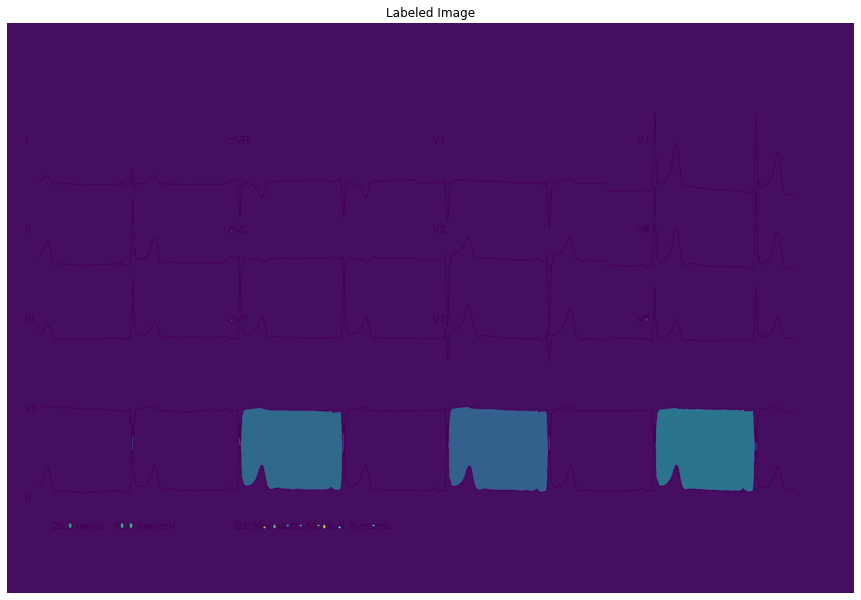


There are 27 labeled components.

Curve 1 line range = [0, 1480].
Curve 2 line range = [997, 1217].
Curve 3 line range = [999, 1212].
Curve 4 line range = [1000, 1216].


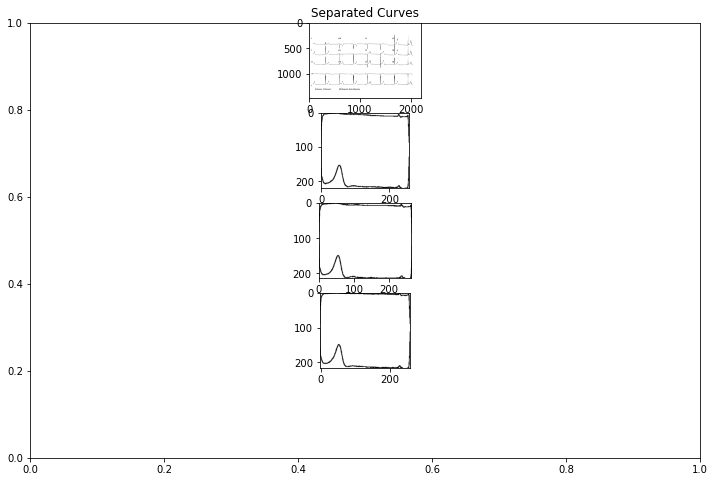

Effective curves are components from indices:  [1, 8, 9, 10]
Their corresponding curve lengths are:  [2200, 258, 263, 257]
Their corresponding curve widths are:  [1480, 220, 213, 216]



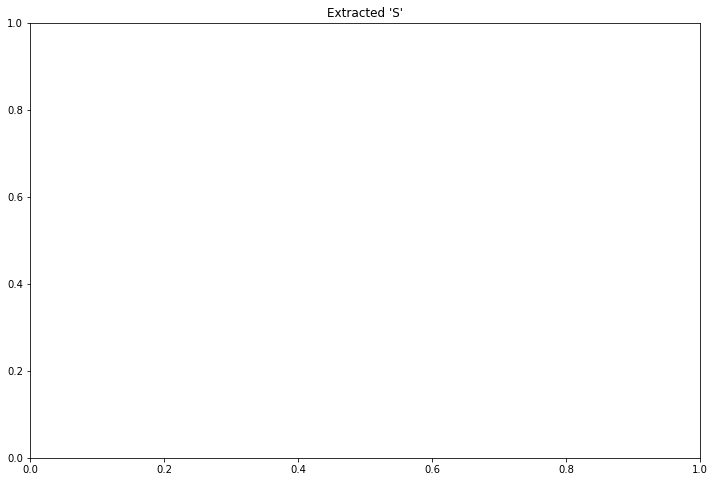

The corresponding baselines for the curves are:  []



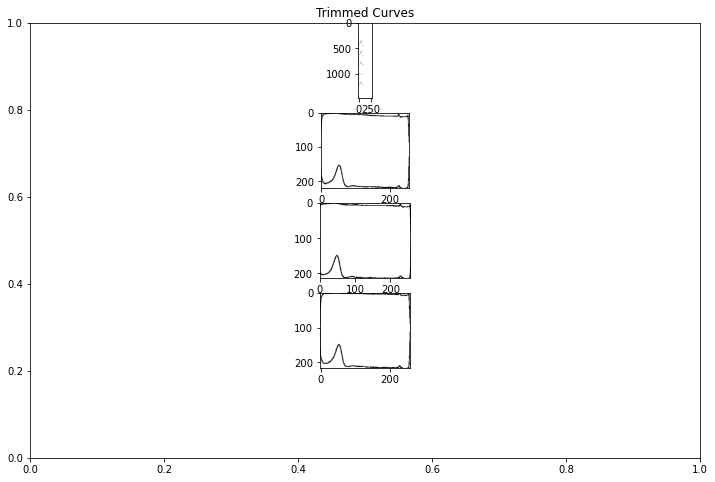

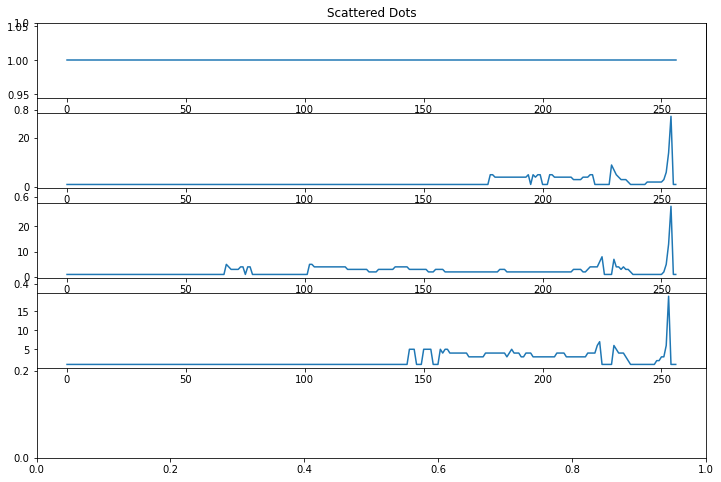

SystemError: tile cannot extend outside image

In [17]:
if __name__ == '__main__':
    main()